In [14]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Sentiment Classifier**

## App Dataset

In [8]:
apps_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Synapse Hackathon/apps_info.csv', index_col=0)
app_reviews_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Synapse Hackathon/apps_reviews.csv', index_col=0)

In [9]:
apps_df

,app_name,description,score,ratings_count,downloads,content_rating,section,categories
app_id,,,,,,,,
1,Western Union Send Money Now,Enjoy a $0 transfer fee* on your next online i...,4.6,317000,10000000,Everyone,Budgeting tools,Finance
2,"Priceline: Hotel, Flight & Car",Save on your next trip with exclusive deals on...,4.7,502000,10000000,Everyone,Business tools,Travel & Local
3,Slack,Slack brings team communication and collaborat...,3.4,134000,10000000,Everyone,Business tools,Business
4,MyWalmart,"Introducing MyWalmart, the one app designed fo...",4.7,211000,1000000,Everyone,Business tools,Business
5,Fidelity Investments,Invest at a firm invested in you. Fidelity’s s...,4.6,182000,5000000,Everyone,Business tools,Finance
...,...,...,...,...,...,...,...,...
213,Target,Enjoy the easiest way to shop and save from an...,3.7,297000,10000000,Everyone,Popular apps,Shopping
214,TikTok Studio,Welcome to TikTok Studio - where innovation me...,4.7,201000,10000000,Teen,Share photos & videos,"#2 top free video players & editors, Video Pla..."
215,Okta Verify,Okta Verify is a lightweight app that allows y...,4.4,34900,10000000,Everyone,Tools & utilities,Productivity


In [10]:
app_reviews_df

,review_text,review_score,review_date,helpful_count
app_id,,,,
1,I don't know what happened to this app. It was...,1,2025-04-03,6
1,app was good. then the randomly locked my acco...,1,2025-04-13,3
1,Terrible user interface 🤬 Menus cluttered. App...,1,2025-03-17,48
1,I got this app to send money quickly without h...,1,2025-02-01,23
1,You're honestly better off using another app o...,1,2024-12-19,22
...,...,...,...,...
217,Tha price is right all the time,5,2016-12-08,0
217,ItsMee..t,5,2020-07-17,0
217,Does everything needed,5,2017-05-31,0


### Dataset Cleaning & Assigning


In [15]:
def cat_sentiment(x):
    if x>=4:
        return 'positive'
    elif x<=2:
        return 'negative'
    else:
        return 'neutral'
app_reviews_df['sentiment']  = app_reviews_df['review_score'].apply(cat_sentiment)

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

app_reviews_df['clean_text']=app_reviews_df['review_text'].apply(clean_text)
sample_df = app_reviews_df.sample(n=20000, random_state=42)

### Data Preparation

In [19]:
texts = sample_df['clean_text'].values
labels = sample_df['sentiment'].values

le = LabelEncoder()
Y = le.fit_transform(labels)
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

max_len = 100
X = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y, test_size=0.2, random_state=42)

### Model Building

In [22]:
em_dim = 100

model = Sequential([
    Embedding(input_dim = max_vocab, output_dim = em_dim, input_length=max_len),
    Bidirectional(LSTM(128, return_sequences =True)),
    Bidirectional(GRU(64, return_sequences= False)),
    Dropout(0.5),
    Dense(64, activation = 'relu'),
    Dropout(0.5),
    Dense(3, activation = 'softmax')])

model.compile(loss ='sparse_categorical_crossentropy', optimizer= 'adam', metrics = ['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### Model Training

In [105]:
early_stop = EarlyStopping(monitor = 'val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    X_train,
    Y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=128,
    callbacks=[early_stop])

Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.5337 - loss: 1.0089 - val_accuracy: 0.6669 - val_loss: 0.8200
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.7087 - loss: 0.7377 - val_accuracy: 0.7119 - val_loss: 0.7218
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.7641 - loss: 0.5912 - val_accuracy: 0.7156 - val_loss: 0.7199
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.7886 - loss: 0.5283 - val_accuracy: 0.6856 - val_loss: 0.8145
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.8133 - loss: 0.4711 - val_accuracy: 0.6825 - val_loss: 0.8229
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.8475 - loss: 0.4069 - val_accuracy: 0.6706 - val_loss: 0.9000


### Model Evaluation

In [106]:
loss, accuracy = model.evaluate(X_test, Y_test)
print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test Loss: {loss:.4f}')

Y_pred_probs = model.predict(X_test)
Y_pred =  Y_pred_probs.argmax(axis=1)

125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 141ms/step - accuracy: 0.7081 - loss: 0.7109
Test Accuracy: 0.7147
Test Loss: 0.7082
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 140ms/step


### Model Visualization

1. Confusion Matrix

              precision    recall  f1-score   support

    negative       0.69      0.89      0.78      1687
     neutral       0.28      0.01      0.02       659
    positive       0.76      0.83      0.79      1654

    accuracy                           0.72      4000
   macro avg       0.57      0.58      0.53      4000
weighted avg       0.65      0.72      0.66      4000



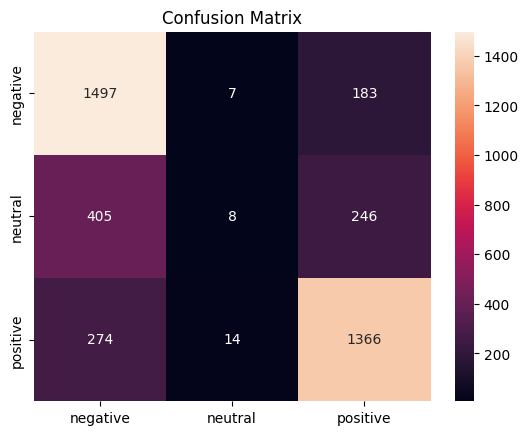

In [32]:
print(classification_report(Y_test, Y_pred, target_names=le.classes_))
matrix = confusion_matrix(Y_test, Y_pred)

matrix=confusion_matrix(Y_test, Y_pred)
sns.heatmap(matrix, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.show()

2. Bar Chart of Sentiment Distribution

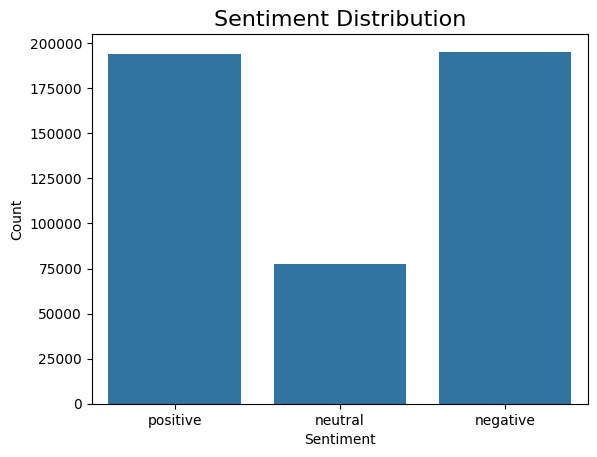

In [40]:
order = ['positive', 'neutral', 'negative']
palette = sns.color_palette("Set2")
ax =sns.countplot(x ='sentiment', data =app_reviews_df, order =order)

plt.title("Sentiment Distribution", fontsize=16)
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

## Games Dataset

In [41]:
games_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Synapse Hackathon/games_info.csv', index_col=0)
game_reviews_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Synapse Hackathon/games_reviews.csv', index_col=0)

In [42]:
games_df

,game_name,description,score,ratings_count,downloads,content_rating,section,categories
game_id,,,,,,,,
1,Geometry Dash SubZero,Geometry Dash is back with a brand new adventu...,4.5,926000,100000000,Everyone,Abstract graphics,"Action, Platformer, Runner, Arcade, Single pla..."
2,Word Collect - Word Games Fun,Download the best word games Free in Word Coll...,4.7,588000,10000000,Everyone,Abstract graphics,"#10 top grossing word, Word, Search, Single pl..."
3,Tap Away,Do you have what it takes to solve all the swi...,4.3,1130000,50000000,Everyone,Abstract graphics,"Puzzle, Logic, Casual, Single player, Abstract..."
4,Sudoku - Classic Sudoku Puzzle,Enjoy the Classic Sudoku Puzzle Game for free!...,4.7,2650000,50000000,Everyone,Abstract graphics,"Puzzle, Logic, Sudoku, Casual, Single player, ..."
5,Woodber - Classic Number Game,Woodber - perfect combination of classic numbe...,4.6,225000,10000000,Everyone,Abstract graphics,"Puzzle, Logic, Casual, Single player, Abstract..."
...,...,...,...,...,...,...,...,...
331,Yatzy - Fun Classic Dice Game,Looking for a free online dice game to play al...,4.8,274000,5000000,Everyone,Stylized games,"#8 top free board, Board, Dice, Casual, Multip..."
332,Dark War Survival,Gear up and brace yourself for the ultimate te...,4.3,534000,10000000,Everyone 10+,Zombie games,"#5 top grossing strategy, Action, Action-adven..."
333,Idle Outpost: Upgrade Games,Idle business simulator and tycoon game with a...,4.1,97000,10000000,Everyone,Zombie games,"Simulation, Management, Tycoon, Casual, Single..."


In [43]:
game_reviews_df

,review_text,review_score,review_date,helpful_count
game_id,,,,
1,"too many ads for a game where you die a lot, g...",1,2025-04-13,2
1,I really love this game and its music. But at ...,1,2023-07-28,3963
1,The app is cool in general. BUT this is meant ...,1,2024-11-04,24
1,I'm gonna say I hate this game so much! Ads al...,1,2020-11-13,158
1,"This game is great, except.... It has 30 secon...",1,2019-02-28,73
...,...,...,...,...
335,Awesome.,5,2025-02-02,0
335,great.,5,2025-01-24,0
335,Good 👍,5,2025-02-08,0


### Dataset Cleaning & Assigning

In [64]:
game_reviews_df['sentiment'] = game_reviews_df['review_score'].apply(
    lambda x: 'positive' if x >= 4 else 'negative' if x <= 2 else 'neutral'
)

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

game_reviews_df['clean_text'] = game_reviews_df['review_text'].apply(clean_text)

sample2_df = game_reviews_df.sample(n=20000, random_state=42)

### Data Preparation

In [65]:
texts = sample2_df['clean_text'].values
labels = sample2_df['sentiment'].values

le = LabelEncoder()
y2 = le.fit_transform(labels)
max_vocab_size = 10000
tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
max_len = 100
X2 = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, stratify=y2, test_size=0.2, random_state=42)

### Model Building

In [67]:
embedding_dim = 100

model = Sequential([
    Embedding(input_dim=max_vocab_size, output_dim=embedding_dim, input_length=max_len),
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(GRU(64, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes: negative, neutral, positive
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Model Training

In [68]:
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

history = model.fit(
    X_train2, y_train2,
    validation_split=0.1,
    epochs=10,
    batch_size=128,
    callbacks=[early_stop]
)

Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.4809 - loss: 1.0209 - val_accuracy: 0.6762 - val_loss: 0.7747
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.6906 - loss: 0.7657 - val_accuracy: 0.6844 - val_loss: 0.7482
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.7323 - loss: 0.6499 - val_accuracy: 0.6837 - val_loss: 0.7432
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.7604 - loss: 0.5772 - val_accuracy: 0.6694 - val_loss: 0.7914
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.8039 - loss: 0.4988 - val_accuracy: 0.6662 - val_loss: 0.8342
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.8379 - loss: 0.4343 - val_accuracy: 0.6612 - val_loss: 0.9410
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.8628 - loss: 0.3547 - val_accuracy: 0.6531 - val_loss: 1.1126


### Model Evaluation

In [69]:
loss2, accuracy2 = model.evaluate(X_test2, y_test2)
print(f'Test Accuracy: {accuracy:.4f}')

125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 143ms/step - accuracy: 0.6665 - loss: 0.7946
Test Accuracy: 0.6625


### Model Visualization

1. Confussion Matrix

125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 141ms/step
              precision    recall  f1-score   support

    negative       0.66      0.75      0.70      1462
     neutral       0.34      0.10      0.16       722
    positive       0.70      0.82      0.76      1816

    accuracy                           0.66      4000
   macro avg       0.57      0.56      0.54      4000
weighted avg       0.62      0.66      0.63      4000



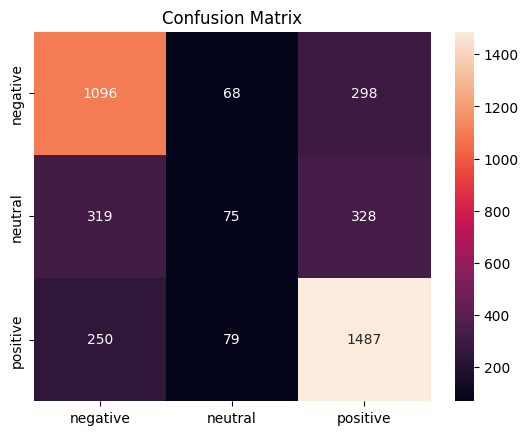

In [73]:
y_pred_probs2 = model.predict(X_test2)
y_pred2 = y_pred_probs2.argmax(axis=1)

print(classification_report(y_test2, y_pred2, target_names=le.classes_))
matrix = confusion_matrix(y_test2, y_pred2)

matrix=confusion_matrix(y_test2, y_pred2)
sns.heatmap(matrix, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.show()

2. Bar Chart of Sentiment Distribution

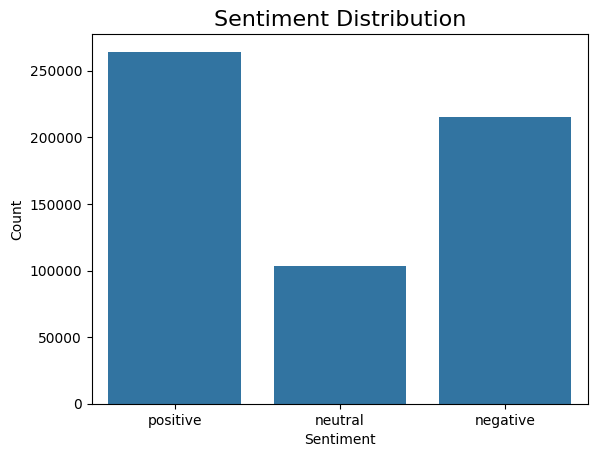

In [74]:
order = ['positive', 'neutral', 'negative']
palette = sns.color_palette("Set2")
ax =sns.countplot(x ='sentiment', data =game_reviews_df, order =order)

plt.title("Sentiment Distribution", fontsize=16)
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

# **Personalized App Recommendations**

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

Combining reviews per app

In [76]:
grouped_reviews = app_reviews_df.groupby('app_id')['review_text']
combined_reviews = grouped_reviews.apply(lambda texts: ' '.join(texts))
app_texts_df = combined_reviews.reset_index()

Generating TF-IDF features

In [77]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(app_texts_df['review_text'])

Computing cosine similarity between apps

In [78]:
cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

Create index mappings

In [79]:
app_id_to_index = pd.Series(data=app_texts_df.index.values, index=app_texts_df['app_id'])
index_to_app_id = pd.Series(data=app_texts_df['app_id'].values, index=app_texts_df.index.values)

Computing average review score per app

In [80]:
average_scores = app_reviews_df.groupby('app_id')['review_score']
avg_scores = average_scores.mean()

### Reccomender Function

In [81]:
def recommend_apps(app_id, top_n=20):
    if app_id not in app_id_to_index:
        print(f"App ID {app_id} not found.")
        return pd.DataFrame()

    idx = app_id_to_index[app_id]
    sim_scores = cosine_sim_matrix[idx]

    sorted_indices = sim_scores.argsort()[::-1]

    top_indices = []
    for i in sorted_indices:
        if i != idx:
            top_indices.append(i)
        if len(top_indices) == top_n:
            break

    recommended_app_ids = []
    for i in top_indices:
        recommended_app_ids.append(index_to_app_id[i])

    similarity_scores = []
    for i in top_indices:
        similarity_scores.append(sim_scores[i])

    avg_review_scores = []
    for app in recommended_app_ids:
        if app in avg_scores:
            avg_review_scores.append(avg_scores[app])
        else:
            avg_review_scores.append(0.0)

    result_df = pd.DataFrame()
    result_df['app_id'] = recommended_app_ids
    result_df['similarity_score'] = similarity_scores
    result_df['avg_review_score'] = avg_review_scores

    result_df = result_df.sort_values(by=['similarity_score', 'avg_review_score'], ascending=False)

    return result_df

Usage:

In [107]:
if 'app_id' not in app_reviews_df.columns:
    app_reviews_df = app_reviews_df.reset_index()

valid_app_ids = set(app_id_to_index.index)

app_id_input = int(input("Enter the app_id for which you want recommendations:  "))

while app_id_input not in valid_app_ids:
    print(f"App ID '{app_id_input}' not found. Please enter a valid app_id.")
    app_id_input = int(input("Enter the app_id for which you want recommendations:  "))

num = int(input("Enter number of app recommendations required: "))

print(f"Top {num} app recommendations for app_id = {app_id_input}")
recommendations = recommend_apps(app_id_input, top_n=num)
print(recommendations)

Enter the app_id for which you want recommendations:  1
Enter number of app recommendations required: 10
Top 10 app recommendations for app_id = 1
   app_id  similarity_score  avg_review_score
0     216          0.638916          3.343897
1      55          0.636612          3.024120
2      15          0.600233          3.000000
3     179          0.594194          2.477710
4     180          0.590832          1.000000
5      58          0.589325          3.000000
6      57          0.588167          3.000000
7       9          0.586374          3.023994
8      14          0.566642          3.021150
9      10          0.560850          3.044155
